In [1]:
sub = '01'
data_root = '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics'

In [2]:
from utils_nb import *
from glob import glob
import os
import pandas as pd
from fnmatch import fnmatch
from math import atan2, degrees
import matplotlib.pyplot as plt


In [56]:
def prep_data_tempInt(subnrs, sesnrs, runnrs, task='SJ', root = 'TempInt_pilot', framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = None):
    """
    goes through root folder, should be bids-like, selects all data for the
    given sub-ses-run-task combination
    
    one just processing the events.tsv and the other one managing the files,
    add sigmoid and gaussian fits
    """
    # init result df lists, to become columns
    soas = [] # stimulus onset asynchrony
    resps = [] # responses
    subs = [] # subject
    sessions = []
    runs = []
    which_first = [] # A or V first?
    
    # select data
    if data_paths is None:
        data_paths = select_data_tempInt(subnrs, sesnrs, runnrs, root = root, task = task, verbose = 0)

    for path in data_paths:
        # load run data
        dat = pd.read_csv(path, sep='\t')
        
        # unpack sub, ses, run from string
        bids_dict = parse_bids_filename(path)
        subnr = bids_dict['sub']
        sesnr = bids_dict['ses']
        runnr = bids_dict['run']
                    
        for trial in dat.trial_nr.unique():    
            # index trial
            trial_df = dat[dat.trial_nr == trial]
            soa = trial_df.soa.iloc[0]

            if task == 'SJ':
                # process SJ
                try:
                    # getting response in response period phase 3
                    response = trial_df[(trial_df.event_type == 'response') & (trial_df.phase == 3)].response.values[0]
                except IndexError:
                    response = None

                # synchonous is coded as 1
                response = 1 if response == 'synchronous' else 0
                resps.append(response)

            else:
                # process TOJ
                try:
                    # getting response in response period phase 3
                    response_correct = trial_df[(trial_df.event_type == 'response') & (trial_df.phase == 3)].correct.values[0]
                except IndexError:
                    response_correct = None

                # correct is coded as 1
                resps.append(response_correct)

            first = trial_df.order.iloc[0][0] # which stimulus type was first, derived from tial type 'AV'/'VA'
            soa = soa if first == 'A' else -soa # making soas for visual first negative

            soas.append(soa)
            subs.append(subnr)
            sessions.append(sesnr)
            runs.append(runnr)
            which_first.append(first)
    
    # make df
    resps_df = pd.DataFrame({'soa_f' : soas, 'neg_soa_f': [-soa for soa in soas], 'soa_ms': [soa*framerate*1000 for soa in soas], 
                             'neg_soa_ms': [-soa*framerate*1000 for soa in soas],
                             'response' : resps, 'subject': subs, 'session':sessions, 'run':runs, 'first':which_first})

    # flipped response coding for V-first trials
    comb_soas = []
    responses_flipped = []

    for i, row in resps_df.iterrows():
        
        if row['first'] == 'V': 
            comb_soas.append(row['neg_soa_f'])
            # flip response
            if row['response'] == 0.0:
                responses_flipped.append(1.0)
            else:
                responses_flipped.append(0.0)

        else:
            comb_soas.append(row['soa_f'])
            responses_flipped.append(row['response'])
            
    resps_df['comb_soa_f'] = comb_soas
    resps_df['comb_soa_ms'] = [comb_soa *framerate*1000 for comb_soa in comb_soas]
    resps_df['responses_flipped'] = responses_flipped
    
    if return_paths:
        return resps_df, data_paths
    else:
        return resps_df

In [47]:
# grab files
paths = []
events_paths = []
edf_paths = []
sj_paths = []
toj_paths = []
sd_paths = []
tr_paths = []

for ses in ['00', '01', '02', '03']:
    ses_paths = glob(os.path.join(data_root, f'sub-{sub}', f'ses-{ses}', '*'))

    tr_paths += [path for path in ses_paths if ('TempRep' in path)]
    sj_paths += [path for path in ses_paths if ('TempIntSJ' in path)]
    toj_paths += [path for path in ses_paths if ('TempIntTOJ' in path)]
    sd_paths += [path for path in ses_paths if  ('SigDet' in path)]
    
    print(f'found {len(ses_paths)} files for ses-{ses}')
    events_paths += [path for path in ses_paths if 'event' in path]
    edf_paths += [path for path in ses_paths if 'edf' in path]
    
    paths += ses_paths
#     print(sd_paths)

# print([path.split('/')[-1] for path in paths if 'events' in path])
print(paths)
sj_paths

found 0 files for ses-00
found 8 files for ses-01
found 0 files for ses-02
found 0 files for ses-03
['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

(array([-0.16973993, 86.94289636]),
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:>)

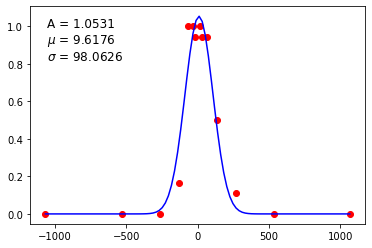

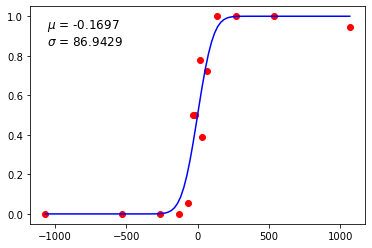

In [60]:
sj_events = [path for path in paths if ('TempIntSJ' in path) and ('events' in path)]
gaussian_init = {'A': 1,'$\mu$':0, '$\sigma$':200} # gaussian
cumnorm_init = {'$\mu$':0, '$\sigma$':200} # cumulative gaussian

data_sj = prep_data_tempInt(None, None, None, task='SJ', root = None, framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = sj_events)
mean_response = data_sj.groupby(['subject', 'soa_ms', 'session', 'run'])['response'].mean().reset_index()
mean_response.columns = ['subject', 'soa_ms', 'session', 'run', 'mean_response']

quick_fit(mean_response.soa_ms, mean_response.mean_response, gaussian, gaussian_init, plot = True)

toj_events = [path for path in paths if ('TempIntTOJ' in path) and ('events' in path)]
data_toj = prep_data_tempInt(None, None, None, task='TOJ', root = None, framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = toj_events)
mean_response = data_toj.groupby(['subject', 'soa_ms', 'session', 'run'])['responses_flipped'].mean().reset_index()
mean_response.columns = ['subject', 'soa_ms', 'session', 'run', 'mean_response']

quick_fit(mean_response.soa_ms, mean_response.mean_response, cumulative_normal, cumnorm_init, plot = True)


In [43]:
sd_paths

[]

In [36]:
ls = ['sub-01_ses-01_task-TempRep_run-03_events.tsv', 'sub-01_ses-01_task-TempRep_run-02_events.tsv', 'sub-01_ses-01_task-TempRep_run-01_events.tsv']
ls.sort()
ls

['sub-01_ses-01_task-TempRep_run-01_events.tsv',
 'sub-01_ses-01_task-TempRep_run-02_events.tsv',
 'sub-01_ses-01_task-TempRep_run-03_events.tsv']

In [17]:
glob(os.path.join(data_root, f'sub-{sub}', f'ses-01', '*'))

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

In [14]:
glob('/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01')

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01']

In [3]:
select_data_tempInt([sub], ['00', '01', '02', '03'], ['01'])

Not found TempInt_pilot/sub-01/ses-00/sub-01_ses-00_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-01/sub-01_ses-01_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-02/sub-01_ses-02_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-03/sub-01_ses-03_task-TempInt_run-01_events.tsv


[]

## Eyetracking

In [37]:
import os
os.path.sep

'/'

In [5]:
from linescanning import dataset, utils

In [8]:
et_file = '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf'

In [9]:
eyetrack_data = dataset.ParseEyetrackerFile(et_file, use_bids = True, verbose = True)


EYETRACKER
Preprocessing /home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf
 Eye:         R
 Sample rate: 1000
 Start time:  1099613.0
 Stop time:   1749781.0
 Duration:    650.168s [650168 samples]
 Fetching:    ['pupil', 'pupil_int', 'gaze_x_int', 'gaze_y_int', 'gaze_x', 'gaze_y']
 Start time:  1099613.0s
 Nr blinks:   48 [0.07 blinks per second]
 Nr saccades: 1252 saccades
Done


In [10]:
eyetrack_data.__dict__

{'eye_attributes': ['df_blinks',
  'df_space_func',
  'df_space_eye',
  'df_saccades'],
 'exp_attributes': ['df_onsets', 'df_rts', 'df_accuracy', 'df_responses'],
 'func_attributes': ['df_func_psc',
  'df_func_raw',
  'df_func_zscore',
  'df_func_ica',
  'df_func_acomp'],
 'all_attributes': ['df_blinks',
  'df_space_func',
  'df_space_eye',
  'df_saccades',
  'df_onsets',
  'df_rts',
  'df_accuracy',
  'df_responses',
  'df_func_psc',
  'df_func_raw',
  'df_func_zscore',
  'df_func_ica',
  'df_func_acomp'],
 'edf_file': '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf',
 'func_file': None,
 'sub': '01',
 'run': '01',
 'task': 'SigDet',
 'TR': 0.105,
 'low_pass_pupil_f': 6.0,
 'high_pass_pupil_f': 0.01,
 'verbose': True,
 'use_bids': True,
 'nr_vols': None,
 'h5_file': '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/eye.h5',
 'report': False,
 'save_as': None,
 'invoked_from_func': False,
 'overwrite': False,
 '

In [11]:
df_gaze = eyetrack_data.df_space_eye
df_gaze = pd.DataFrame(df_gaze)
df_gaze = df_gaze.reset_index()

df_gaze_right = utils.select_from_df(df_gaze, expression = 'eye = R')
df_gaze_right.columns
# df_gaze
t = df_gaze_right.t.values

In [12]:
df_gaze_right

,index,subject,run,eye,t,pupil,pupil_psc,pupil_int,pupil_int_psc,gaze_x_int,gaze_x_int_psc,gaze_y_int,gaze_y_int_psc,gaze_x,gaze_x_psc,gaze_y,gaze_y_psc
0,0,01,01,R,0.000,1429.0,8.365623,1402.415039,5.239311,1238.901978,30.362579,301.926086,-44.715389,952.700012,0.466049,416.899994,-24.333084
1,1,01,01,R,0.001,1431.0,8.515015,1402.415039,5.239311,1238.901978,30.362579,301.926086,-44.715389,949.799988,0.151733,415.500000,-24.595337
2,2,01,01,R,0.002,1434.0,8.739090,1402.415039,5.239311,1238.901978,30.362579,301.926086,-44.715389,947.799988,-0.065033,412.100006,-25.232224
3,3,01,01,R,0.003,1431.0,8.515015,1402.415039,5.239311,1238.901978,30.362579,301.926086,-44.715389,950.299988,0.205925,413.200012,-25.026169
4,4,01,01,R,0.004,1430.0,8.440315,1402.415039,5.239311,1238.901978,30.362579,301.926086,-44.715389,951.900024,0.379341,408.799988,-25.850395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650162,650162,01,01,R,650.162,1083.0,-17.478195,1184.379028,-10.535851,957.711365,0.841095,575.198486,5.023239,939.200012,-0.997124,552.000000,0.974075
650163,650163,01,01,R,650.163,1082.0,-17.552887,1184.379028,-10.535851,957.711365,0.841095,575.198486,5.023239,940.799988,-0.823715,550.099976,0.618164
650164,650164,01,01,R,650.164,1082.0,-17.552887,1184.379028,-10.535851,957.711365,0.841095,575.198486,5.023239,939.299988,-0.986290,550.799988,0.749290
650165,650165,01,01,R,650.165,1081.0,-17.627579,1184.379028,-10.535851,957.711365,0.841095,575.198486,5.023239,940.099976,-0.899582,551.599976,0.899147


In [32]:
dis_to_screen = 210 # Distance from participant to the screen in cm
size_scr_hor = 1920 # width of the screen in pixels
size_scr_ver = 1080 # height of the screen in pixels
monitor_width = 69.8 # width of the screen in cm
x_cor_fixcross = size_scr_hor/2 # x-coordinate of the fixation cross
y_cor_fixcross = size_scr_ver/2 # y-coordinate of the fixation cross

# x_coor_pix_left = df_gaze_left.loc[:,"gaze_x_int"] # Eyetracking data for gaze
# y_coor_pix_left = df_gaze_left.loc[:,"gaze_y_int"]
x_coor_pix_right = df_gaze_right.loc[:,"gaze_x_int"] # Eyetracking data for gaze
y_coor_pix_right = df_gaze_right.loc[:,"gaze_y_int"]
# x_coor_relfix_left = (x_coor_pix_left - x_cor_fixcross) # Pixels relative to the fixation cross
# y_coor_relfix_left = (y_coor_pix_left - y_cor_fixcross)
x_coor_relfix_right = (x_coor_pix_right - x_cor_fixcross) # Pixels relative to the fixation cross
y_coor_relfix_right = (y_coor_pix_right - y_cor_fixcross)

deg_per_pix = degrees(atan2(.5*monitor_width,dis_to_screen))/(.5*size_scr_hor) # How many degrees is one pixel

# visual_angle_x_left = np.array(x_coor_relfix_left*deg_per_pix) # x coordinate visual angle for left eye
# visual_angle_y_left = np.array(y_coor_relfix_left*deg_per_pix) # y coordinate visual angle for left eye
# eccentricity_left = (visual_angle_x_left**2 + visual_angle_y_left**2) **0.5 # Eccentricity for left eye
visual_angle_x_right = np.array(x_coor_relfix_right*deg_per_pix) # x coordinate visual angle for right eye
visual_angle_y_right = np.array(y_coor_relfix_right*deg_per_pix) # y coordinate visual angle for left eye
eccentricity_right = (visual_angle_x_right**2 + visual_angle_y_right**2) **0.5 # Eccentricity for right eye

# pupil_size_left = df_gaze_left["pupil_int"].values
pupil_size_right = df_gaze_right["pupil_int"].values


In [33]:
visual_angle_x_right
np.max(visual_angle_y_right)
np.min(visual_angle_y_right)

-3.7379422

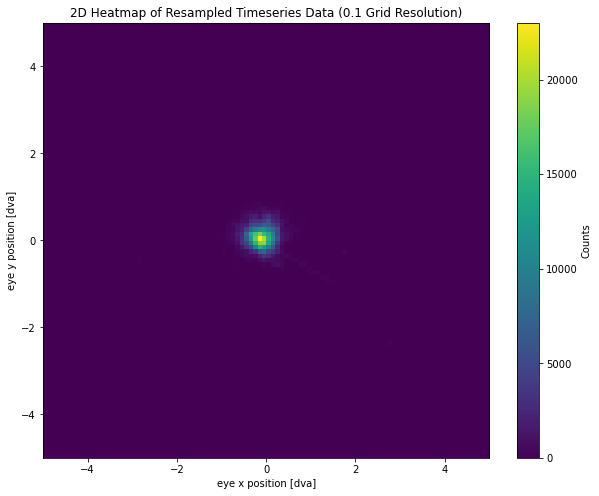

In [34]:
bin_edges = np.arange(-5, 5.1, 0.1)  # creates edges from -10 to 10 with step 0.1

# Create 2D histogram with specified bin edges
hist, xedges, yedges = np.histogram2d(visual_angle_x_right, visual_angle_y_right, bins=[bin_edges, bin_edges])
# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(hist.T, origin='lower', aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('eye x position [dva]')
plt.ylabel('eye y position [dva]')
plt.title('2D Heatmap of Resampled Timeseries Data (0.1 Grid Resolution)')
plt.show()

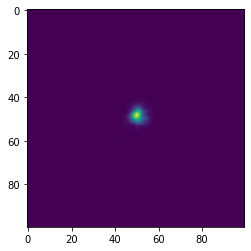

In [35]:
plt.imshow(hist)
plt.show()

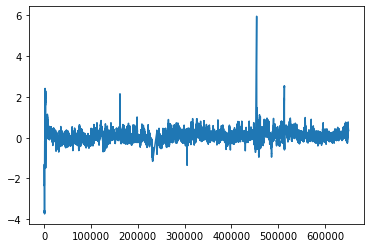

In [18]:
plt.plot(visual_angle_y_right)
plt.show()

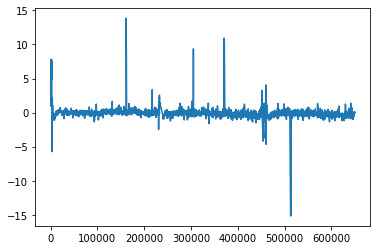

In [30]:
plt.plot(visual_angle_x_right)

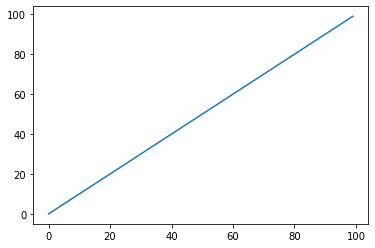

In [19]:
plt.plot(np.arange(100))